# Create Gaussian random fields with lya survey geometry to compute $C_{\ell}(k)$
- [x] generate GRFs with Lya bias and beta
- [x] draw skewers through box
- [x] FFT each skewer and construct $\delta_{2D}$ matrix
    - [x] do discrete version where multiplication of $\exp(i\mathbf(k)\mathbf{\chi})$
- [x] matrix of shape: (N_qso x N_kbins), so that in row i: ($\delta_F(k_0), \dots,\delta_F(k_N)$)
- [x] compute $$a_{\ell m}(\mathbf{k}) = \sum_j^{N_q} \delta_{2D}(x,y,z,k_i)Y_{\ell m}^{\ast}(x,y,j)$$
- [x] compute $$\hat{C}_{\ell}(k_i) = \texttt{hp.alm2cl}(a_lm(k_i))$$
- [ ] compute theory Eq. 2.13 in draft

In [1]:
%matplotlib inline
import numpy as np
from matplotlib_params_file import *
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, legendre
from scipy.integrate import simps
from numba import jit
import multiprocessing as mp
import healpy as hp
from scipy.linalg import dft

#camb
import camb 
from camb import model, initialpower

In [7]:
import GRF_class as my_GRF

In [8]:
GRF = my_GRF.PowerSpectrumGenerator(add_rsd=True)

Fundamental mode k_f= 0.004553032831289555
max mode k_f= 2.0188375532346075
Nyquist frequency: 1.165576404810126
ratio of Nyquist to fundamental freq 256.0
ratio of max to Nyquist freq 1.7320508075688774
get power spectrum from CAMB
define k grid
compute amplitudes
Include anisotropies True
compute mu = k_los / |k|
bias 1.0
beta 1.5
Transforming amplitudes to density field


In [9]:
k_eff, p0, p2, p4, counts, totcounts = GRF.compute_power_spectrum()

compute power spectrum
134217726.0
134217728
134217728


In [11]:
dens = GRF.dens

## Theory power spectrum for Gaussian random field

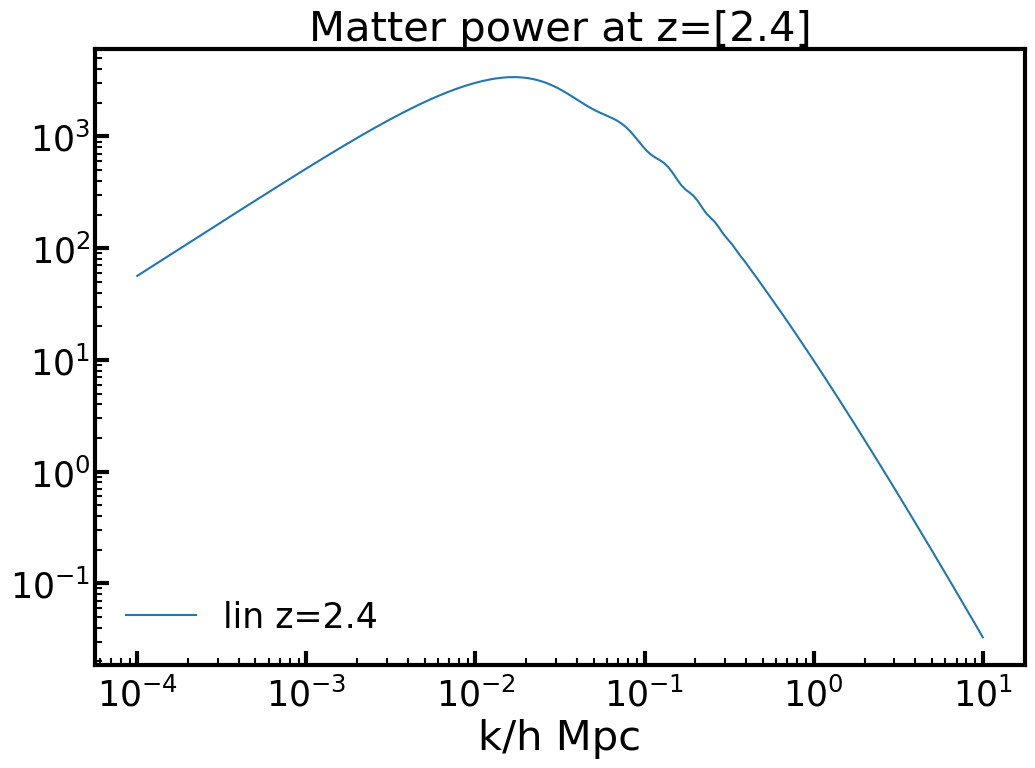

In [4]:
### Generate theory power spectrum
## get CAMB linear matter power

h = 0.6770
Omega_b = 0.04904
Omega_m = 0.3147
ns = 0.96824
As = 2.10732e-9
mnu = 0.0
H0 = h*100
ombh2 = Omega_b*h**2.
omch2 = (Omega_m-Omega_b)*h**2.

pars = camb.CAMBparams()
#z=2.4 approx eBOSS DR16 effective redshift
z=[2.4]
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu)
pars.InitPower.set_params(ns=ns,As=As)
#Note non-linear corrections couples to smaller scales than you want 
pars.set_matter_power(redshifts=z, kmax=50)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh_lin, z_lin, pk_lin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 200)

for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    plt.loglog(kh_lin, pk_lin[i,:], ls = line)
#plt.plot(kh_lin, Plin(kh_lin), 'C2-.')
plt.xlabel('k/h Mpc');
plt.legend(['lin z={:1.1f}'.format(z[0]), 'nbodykit Plin'], loc='lower left');
plt.title('Matter power at z=%s'%z);

def get_multipoles(bias, beta, pk):
    # monopole
    p0 = bias**2 * (1. + 2.*beta/3. + beta**2. / 5. ) * pk
    # quadrupole
    p2 = bias**2 * (4.*beta/3. + 4.*beta**2. / 7.) * pk
    # hexadecapole
    p4 = bias**2 * (8. * beta**2. / 35.) * pk
    return p0, p2, p4

In [5]:

### Calculate Fourier modes
# N=256 #number of cells (relatively large to try and limit discreteness effects)
N=512 # high res

L=1380. # box size in [h^-1.Mpc] cell size*n_x
bins = 30 #number of bins in k from which the power spectrum P will be estimated

k_f=2 * np.pi/L
print('Fundamental mode k_f=',k_f)

kfft=np.fft.fftfreq(N)*2.0*np.pi/L*N # deal with frequencies corresponding to FFT 
kminfft=np.amin(np.abs(kfft)) # find min frequency (probably zero)
kmaxfft=np.amax(np.abs(kfft)) # find max frequencey (Nyquist) - can be negative
kmax=np.sqrt(3)*kmaxfft # max mode k 
print('max mode k_f=',kmax)
kmin=kminfft # min mode k 

kNy=kmaxfft; print('Nyquist frequency:', kNy) # Nyquist frequency
k_bins = np.geomspace(1.e-4,kmax,bins+1)
k_bin_ctrs=(k_bins[1:]+k_bins[:-1])/2.0

print('ratio of Nyquist to fundamental freq',kNy/k_f) # with N=128
print('ratio of max to Nyquist freq',kmax/kNy) # with np.sqrt(3) ratio

Fundamental mode k_f= 0.004553032831289555
max mode k_f= 2.0188375532346075
Nyquist frequency: 1.165576404810126
ratio of Nyquist to fundamental freq 256.0
ratio of max to Nyquist freq 1.7320508075688774


### Define power spectrum functions

In [6]:
@jit(nopython=True)
def compute_mu3d(n):
    print('compute mu = k_los / |k|')
    mu  = np.ones((n,n,n))
    for i in range(n):
        for j in range(n):
            for l in range(n):
                kx=kfft[i]
                ky=kfft[j]
                kz=kfft[l]
                k_sum=np.sqrt(kx**2.0 + ky**2.0 + kz**2.0) # module of distance of origin to compute P(k)
                mu[i,j,l]=kz/(1e-10+k_sum) # angle to z axis
    return mu

@jit(nopython=True)
def get_ks3d(L, n):
    kk  = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for l in range(n):
                kx=kfft[i]
                ky=kfft[j]
                kz=kfft[l]
                k_sum=np.sqrt(kx**2.0 + ky**2.0 + kz**2.0) # module of distance of origin to compute P(k)
                kk[i,j,l]=k_sum
    return kk


@jit(nopython=True)
def get_amplitudes3d(L, n, Pk, beta, mu):
    areal = np.zeros((n,n,n))
    aim = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for l in range(np.int32(n/2+1)):
            #for l in range(n):
                pk = Pk[i,j,l]
                if (i==0 or i==np.int32(n/2)) and (j==0 or j==np.int32(n/2)) and (l==0 or l==np.int32(n/2)):
                    areal[i,j,l] =  np.random.normal(0., np.sqrt(pk/2.)) * ( 1. + beta * (mu[i,j,l])**2)
                    aim[i,j,l]   = 0 # real value for k=0 and Nyquist frequency at i,j,l = N/2
                else:
                    areal[i,j,l] =  np.random.normal(0., np.sqrt(pk/2.)) * ( 1. + beta * (mu[i,j,l])**2)
                    aim[i,j,l]   =  np.random.normal(0., np.sqrt(pk/2.)) * ( 1. + beta * (mu[i,j,l])**2) #1./np.sqrt(2) * --> no need for this factor
                    areal[(n-i)%n][(n-j)%n][(n-l)%n] = areal[i,j,l]
                    aim[(n-i)%n][(n-j)%n][(n-l)%n]   = -aim[i,j,l]
    a = areal + 1.0j*aim
    return a #(h/Mpc)**3

@jit(nopython=True)
def compute_amplitudes3d(L, n, Pk, bias, beta, aniso):
    print('Include anisotropies', aniso)
    if aniso:
        mu = compute_mu3d(n)
    else:
        mu  = np.zeros((n,n,n))
        beta = 0.
    print('bias', bias)
    print('beta', beta)
    print('mu', mu[:2,:2,:2].ravel())
    return bias * get_amplitudes3d(L, n, Pk, beta, mu) #(h/Mpc)**3

def density_field(a, L, n, d=3):
    #dimension d=3
    print('Transforming amplitudes to density field')
    boxvol = float(L)**d
    pix    = (float(L)/float(n))**d
    dens   = np.fft.ifftn(a) * boxvol ** (1./2.) / pix
    #dens *= 1./np.sqrt(2*np.pi)**d
    print('dens:',np.mean(dens), np.min(dens), np.max(dens))
    #assert(np.max(abs(np.imag(dens)))<1e-10, 'Density field should be entirely real')
    return np.real(dens)


### Compute amplitudes and k 
- $P_F(k, \mu, z) = b_F(z)^2 (1+\beta_F(z)\mu^2)^2 P_{L}(k)$, thus, for the amplitudes compute $\delta_F \propto b * (\delta_m + \beta \mu^2 \delta_m)$
- coadd both boxes

In [7]:
add_rsd = True
# define bias and beta
my_bias = 1.
my_beta = 1.5
plin = interp1d(kh_lin, pk_lin[0,:], fill_value="extrapolate")
all_ks_3d = get_ks3d(L, N)
pk_all = plin(all_ks_3d)
# set seed 
np.random.seed(100)

# compute isotropic box (no beta!)
amplitudes_iso         = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=0., aniso=False)
amplitudes_squared_iso = np.real(amplitudes_iso*np.conj(amplitudes_iso))

#compute density field from amplitudes
dens_iso = density_field(amplitudes_iso, L, N)
# set seed 
np.random.seed(100)

amplitudes_aniso       = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=my_beta, aniso=True)
amplitudes_squared_tot   = np.real(amplitudes_aniso*np.conj(amplitudes_aniso))

#compute density field from amplitudes
dens = density_field(amplitudes_aniso, L, N)


Include anisotropies False
bias 1.0
beta 0.0
mu [0. 0. 0. 0. 0. 0. 0. 0.]
Transforming amplitudes to density field
dens: (2.5994354939920644e-05+0j) (-4.975018892679529+0j) (4.966671286418478+0j)
Include anisotropies True
compute mu = k_los / |k|
bias 1.0
beta 1.5
mu [0.         0.99999998 0.         0.70710677 0.         0.70710677
 0.         0.57735026]
Transforming amplitudes to density field
dens: (-5.894957184849883e-06+0j) (-7.573613394847681+0j) (7.523480371767849+0j)


## Compute power spectrum 
- Spherically average amplitudes squared in k-shells


In [8]:
@jit(nopython=True)
def compute_Pk(n, amplitudes_squared):
    Phat = np.zeros(bins)
    Phat2 = np.zeros(bins)
    Phat4 = np.zeros(bins)
    k_eff = np.zeros(bins)
    counts = np.zeros(bins) # initialize counts of mode
    totcounts=0
    for i in range(n):
        for j in range(n): 
            for l in range(n):
                totcounts+=1
                kx=kfft[i]
                ky=kfft[j]
                kz=kfft[l]
                k_sum=np.sqrt(kx**2.0 + ky**2.0 + kz**2.0) # module of distance of origin to compute P(k)
                mu   = kz/(1e-10+k_sum) # angle to z axis
                l2mu = (3.*mu**2.-1.)/2.
                l4mu = (35.*mu**4.-30.*mu**2. + 3.)/8.

                for m in range(bins):
                    if (k_sum>=k_bins[m] and k_sum<k_bins[m+1]): # check if in bin
                        Phat[m]  += amplitudes_squared[i,j,l] # measure monopole
                        Phat2[m] += amplitudes_squared[i,j,l]*(2.*2.+1.)*l2mu # measure quadrupole
                        Phat4[m] += amplitudes_squared[i,j,l]*(2.*4.+1.)*l4mu # measure hexadecapole
                        k_eff[m] += k_sum
                        counts[m]+= 1.

    # normalization 
    Phat /=counts # P over number of modes
    Phat2/=counts
    Phat4/=counts
    k_eff/=counts

    print(sum(counts))
    print(totcounts)
    print(N**3)
    return k_eff, Phat, Phat2,Phat4, counts,totcounts


In [9]:
# compute power spectra
k_eff_iso, Phat_iso, Phat2_iso, Phat4_iso,counts,totcounts = compute_Pk(N, amplitudes_squared_iso)
k_eff_tot, Phat_tot, Phat2_tot,Phat4_tot, counts,totcounts = compute_Pk(N, amplitudes_squared_tot)
# normalize power spectrum
k_diff = k_bins[1:]-k_bins[:-1]
dk=k_bins[1]-k_bins[0]

V   = L ** 3 # volume of box
N_c = N # number of cells
V_k = 4.0 * np.pi * (k_bins[1:]**3.0-k_bins[:-1]**3.0)/3.0 # 

V_f=k_f**3.0

N_k = V_k / V_f

norm_const = V / (N_c**6) # P=1/V <\delta \delta>, but each \delta needs units of volume V/N_c^3

# normalize P(k)
#Phat_iso_final = Phat_iso*norm_const
#Phat2_iso_final = Phat2_iso*norm_const
### compute theory


134217726.0
134217728
134217728
134217726.0
134217728
134217728


In [10]:
# theory power spectrum isotropic --> beta = 0
p0_iso, p2_iso, p4_iso = get_multipoles(bias=my_bias, beta=0.,      pk=pk_lin[0,:])
# theory power spectrum anisotropic --> beta = my_beta
p0, p2, p4             = get_multipoles(bias=my_bias, beta=my_beta, pk=pk_lin[0,:])


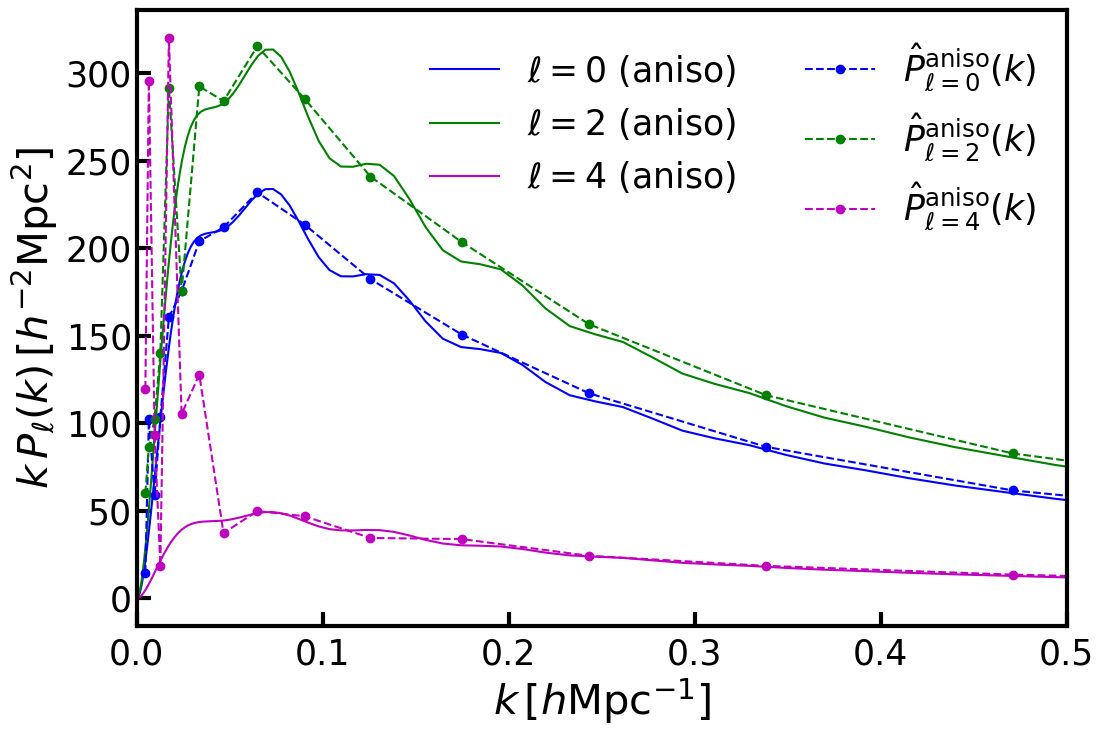

In [11]:
### compare theory to measurement

plt.plot(kh_lin, kh_lin*p0, 'b-', label=r'$\ell=0$ (aniso)')
plt.plot(kh_lin, kh_lin*p2, 'g-', label=r'$\ell=2$ (aniso)')
plt.plot(kh_lin, kh_lin*p4, 'm-', label=r'$\ell=4$ (aniso)')
plt.plot(k_eff_tot, k_eff_tot*Phat_tot, 'bo--',label=r'$\hat{P}_{\ell=0}^{\mathrm{aniso}}(k)$')
plt.plot(k_eff_tot, k_eff_tot*abs(Phat2_tot), 'go--',label=r'$\hat{P}_{\ell=2}^{\mathrm{aniso}}(k)$')
plt.plot(k_eff_tot, k_eff_tot*abs(Phat4_tot), 'mo--',label=r'$\hat{P}_{\ell=4}^{\mathrm{aniso}}(k)$')
plt.xlabel(r'$k\,[h$Mpc$^{-1}]$')
plt.ylabel(r'$k\,P_\ell(k)\,[h^{-2}$Mpc$^{2}]$')
plt.legend(ncol=2);plt.xlim(0., 0.5);
#plt.ylim(0., 320)
plt.show()


## Sample skewers
- Note that we apply a shift along the z axis. This is necessary to ensure that the $\mu$ angle is with respect to the z-axis
- computes $\mu$ with respect to the combined line-of-sight; $(\vec{r}_i+\vec{r}_j)/2$

In [12]:
add_rsd = False

In [13]:
if add_rsd:
    iso_str = '_aniso'
    amplitudes         = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=my_beta, aniso=True)
else:
    iso_str = ''
    # compute isotropic box (no beta!)
    print('isotropic box')
    amplitudes         = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=0., aniso=False)

amplitudes_squared = np.real(amplitudes*np.conj(amplitudes))
#compute density field from amplitudes
dens = density_field(amplitudes, L, N)

isotropic box
Include anisotropies False
bias 1.0
beta 0.0
mu [0. 0. 0. 0. 0. 0. 0. 0.]
Transforming amplitudes to density field
dens: (-8.812658303975687e-06+0j) (-4.589157757295443+0j) (4.935975793565418+0j)


### extract full length skewers through the box

In [14]:
shift_box = True
shift = 5e+3 if shift_box else 0.

In [17]:
def process_skewers(N, L, dens, shift = 5e+3):
    """
    Process skewers for a 3D grid and compute related fields.

    Parameters:
    N (int): The number of points along each axis of the 3D grid.
    L (float): The length of the side of the 3D box.
    dens (np.array): The density field of the 3D grid.
    shift (float): The displacement value for the z-coordinates.

    Returns:
    tuple: Processed coordinates (all_x, all_y, all_z), all_w_rand, all_w_gal, and all_hpx.
    """
    # Generate 3D meshgrid coordinates
    coords = np.meshgrid(*[np.linspace(0, L, N) for _ in range(3)])

    # Generate skewers
    Nskew = int(1.3e+5)
    np.random.seed(100)
    inds = np.unique(np.random.randint(0, N, size=(Nskew, 2)), axis=0)
    Nskew = len(inds)
    print("N_skew = %d / %d" % (Nskew, N**2))

    # Compute density skewers and add 1
    dens_lya = dens[inds[:,0], inds[:,1], :] 
    skewer_field = dens_lya + 1.

    # Displace the box in the z-direction
    print("Displacing box by %.3e" % shift)
    tmp_all_x = coords[0][inds[:,0], inds[:,1], :]  # + shift
    tmp_all_y = coords[1][inds[:,0], inds[:,1], :]  # + shift
    tmp_all_z = coords[2][inds[:,0], inds[:,1], :] + shift

    # Swap coordinates
    all_x = tmp_all_z.copy()
    all_y = tmp_all_y.copy()
    all_z = tmp_all_x.copy()

    # Define mask (in draft: K_j(chi))
    all_w_rand = np.ones_like(all_x, dtype='float')
    
    # Define delta (in draft: delta_F(chi))
    all_w_gal = np.asarray(skewer_field, dtype='float')

    return all_x, all_y, all_z, all_w_rand, all_w_gal

In [16]:
all_x, all_y, all_z, all_w_rand, all_w_gal = process_skewers(N, L, dens, shift)

shift box 5000.0
N_skew = 102498 / 262144
Displacing box by 5.000e+03


In [18]:
Nskew = all_x.shape[0]

In [19]:
def compute_theta_phi_skewer_start(x,y,z):
    # only compute the Theta, Phi angle for the *first* pixel of the Lya skewer

    xsq = x ** 2.
    ysq = y ** 2.

    s = (xsq + ysq) ** 0.5

    # convert to degrees
    phi = np.arctan2(y, x)
    theta = np.arctan2(s, z)
   
    return theta, phi

In [20]:
all_theta, all_phi = compute_theta_phi_skewer_start(all_x[:,0], all_y[:,0], all_z[:,0])
chi_grid = all_x[0,:]

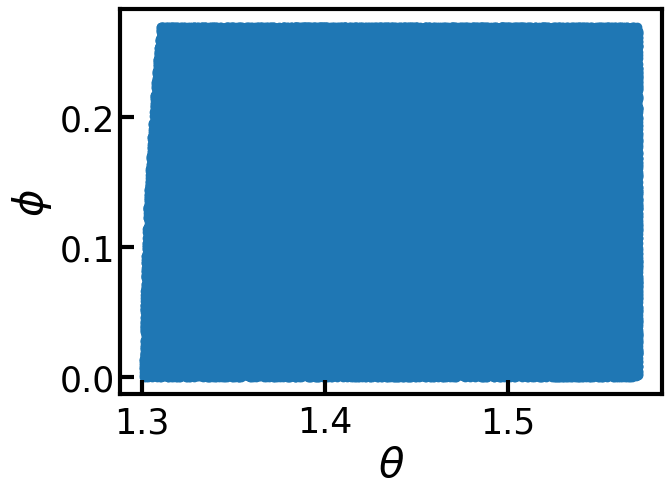

In [21]:
# theta, phi positions of skewers in the sky 
plt.figure(figsize=(7,5));plt.scatter(all_theta, all_phi);plt.xlabel(r'$\theta$');plt.ylabel(r'$\phi$');plt.show()

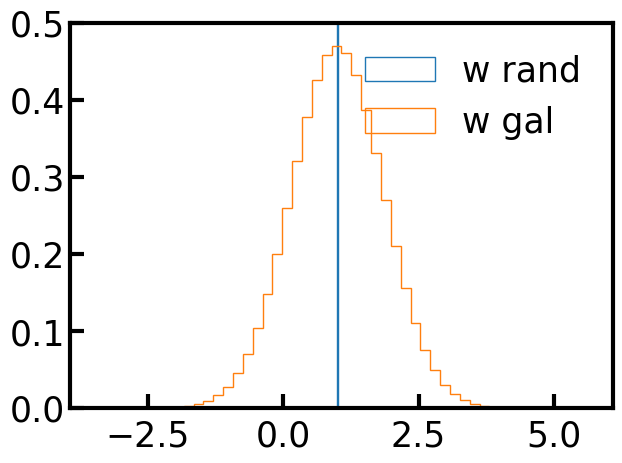

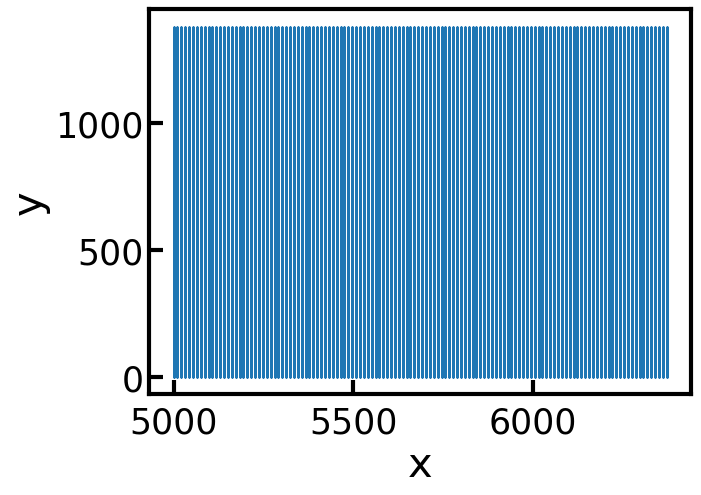

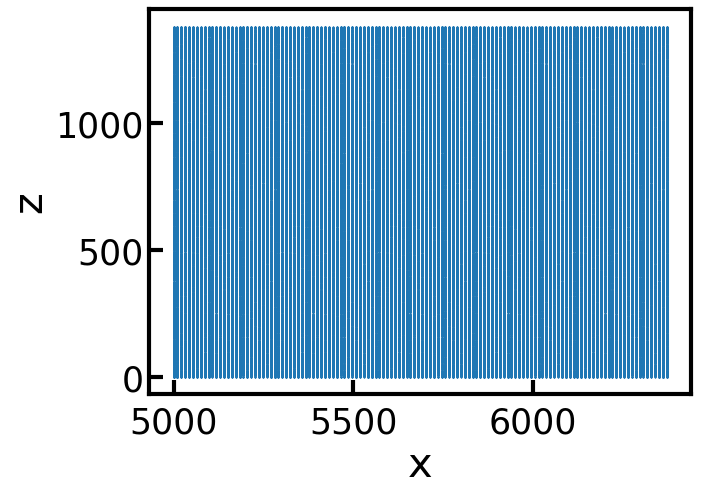

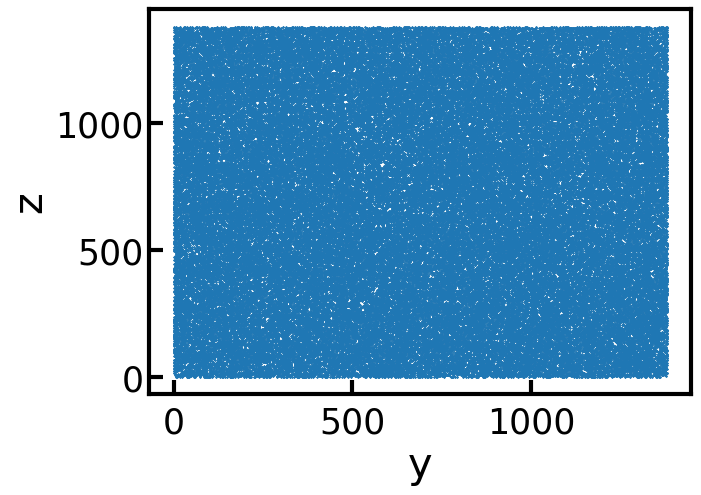

In [22]:
### Plot distribution of weights
plt.figure(figsize=(7,5));
plt.hist(all_w_rand.ravel(),density=True,histtype='step', bins=50, label='w rand');
plt.hist(all_w_gal.ravel(),density=True, histtype='step',bins=50, label='w gal');
plt.ylim(0., 0.5);plt.legend()
plt.show()

#### Visually check if skewers are taken through box
plt.figure(figsize=(7,5));plt.scatter(all_x.ravel()[::100],all_y.ravel()[::100],s=0.1);plt.xlabel('x');plt.ylabel('y');plt.show()
plt.figure(figsize=(7,5));plt.scatter(all_x.ravel()[::100],all_z.ravel()[::100],s=0.1);plt.xlabel('x');plt.ylabel('z');plt.show()
plt.figure(figsize=(7,5));plt.scatter(all_y.ravel()[::100],all_z.ravel()[::100],s=0.1);plt.xlabel('y');plt.ylabel('z');plt.show()

## compute discrete Fourier transform of matrix $N_{qso} \times N_{pix}$

- compute $\delta_{2D}(\hat{n}_j;k)$ for $\delta_{3D}=\delta_F(\chi\hat{n}_j)$ along each QSO sightline, $\hat{n}_j$, using FFTs [or as matrix-vector multiply of $\exp[ik\chi]$] with $K_j(\chi)\delta_F(\chi)$.
- Since the DESI QSO spectra all share a common wavelength grid, the ``matrix'' can be computed once.  It is convenient to store the real and imaginary parts separately.  
- same procedure on $K_j(\chi)$ not weighted by $\delta_F$ gives $\widetilde{K}_j(k)$.

- use $\delta_{2D}(\hat{n}_j;k)$ as weights for each QSO
- perform a spherical harmonic transform for each $k$
- For $\ell_{\rm max}=10^3$ and $10^6$ QSOs this takes a few seconds for each of the real and imaginary parts for each $k$.  
- Squaring the results and averaging over $m$ gives $C_\ell(k)$, which can be binned into bins of $\ell$ and normalized as desired.  

- compute the window matrix.  This is independent of the data, depending only upon the chosen weights, $K_j(\chi)$, and the QSO positions, $\hat{n}_j$.  If the matrix $\hat{n}_j\cdot\hat{n}_k$ is pre-computed, the sum over $\lambda$ can be done with recurrence relations and the final sum over $jk$ is a matrix product and trace though the final object depends upon $\ell$ (normally binned), $L$ and $k-k'$ and so can be large.  For very large numbers of sightlines, the sum over $j$ can be done in batches using the same procedure.


In [23]:
# # simple sin test case 
# N_sin=1000
# sin_grid = np.linspace(0, 10*np.pi, N_sin)
# sin_vals = np.sin(sin_grid)
# dx=np.diff(sin_grid)[0]
# k_arr = np.fft.fftfreq(N_sin, d=dx)
# FT_mat = np.exp(-2.*np.pi*1j * np.outer(sin_grid, k_arr))
# FT_sin = np.dot(sin_vals, FT_mat)
# fft_sin = np.fft.fft(sin_vals)
# DFT_mat = dft(len(sin_grid))
# DFT_sin = np.dot(sin_vals, DFT_mat)

# plt.figure(figsize=(7,4))
# plt.plot(k_arr, fft_sin, label='np.fft.fft')
# plt.plot(k_arr, FT_sin,ls='--', label='my FT')
# plt.plot(k_arr, DFT_sin,ls=':', label='DFT')
# plt.xlim(0.0, 0.5)
# plt.axvline(1/(2*np.pi), c='k')
# plt.legend();plt.show()

In [24]:
def compute_dft_scipy(chi_grid, mask, delta):
    # Ensure that chi_grid has a uniform step size
    diffs = np.diff(chi_grid)
    dx = diffs[0]
    assert np.allclose(diffs, dx), "Not all values in np.diff(chi_grid) are identical."

    # Number of points
    N = len(chi_grid)

    # Define k-array for Fourier transform
    k_arr = np.fft.fftfreq(N, d=dx)

    FT_mat = dft(N)
    # Perform the DFT using matrix multiplication
    FT_mask  = np.dot(mask, FT_mat)
    FT_delta = np.dot(delta, FT_mat)
    return k_arr, np.real(FT_mask), np.real(FT_delta)

In [25]:
def compute_dft(chi_grid, mask, delta):
    """
    Compute the Discrete Fourier Transform

    Parameters:
    chi_grid (np.array): Input array representing the chi grid.
    mask (np.array): Input array of mask values.
    delta (np.array): Input array of delta values for the Lya forest.

    Returns:
    tuple: The DFT results of mask and delta.
    """
    # Ensure that chi_grid has a uniform step size
    diffs = np.diff(chi_grid)
    dx = diffs[0]
    assert np.allclose(diffs, dx), "Not all values in np.diff(chi_grid) are identical."

    # Number of points
    N = len(chi_grid)

    # Define k-array for Fourier transform
    k_arr = np.fft.fftfreq(N, d=dx)

    # Define the Fourier matrix (Vandermonde matrix)
    # FT definition using -2*pi
    FT_mat = np.exp(-2.j * np.pi * np.outer(chi_grid, k_arr))

    # Perform the DFT using matrix multiplication
    FT_mask = np.dot(mask, FT_mat)
    FT_delta = np.dot(delta, FT_mat)
    return k_arr, np.real(FT_mask), np.real(FT_delta)
#k_arr, FT_mask, FT_delta = compute_dft(chi_grid, all_w_rand, all_w_gal)

In [26]:
k_arr, FT_mask, FT_delta = compute_dft_scipy(chi_grid, all_w_rand, all_w_gal)

### use directSHT to compute $C_{ell}$

In [27]:
import sys
%env JAX_ENABLE_X64=True
#
sys.path.insert(0, '/global/homes/r/rmvd2/lya_Cl/directsht-lya/')
from sht.sht                import DirectSHT
from sht.mocks              import LogNormalMocks
from sht.mask_deconvolution import MaskDeconvolution
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

env: JAX_ENABLE_X64=True
gpu


In [28]:
# Set up an sht instance.
Nl   = 500
Nx   = 2*Nl
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

For general, Direct SHT has Nl= 500 , Nx= 1000  and xmax= 0.625
For randoms, Direct SHT has Nl= 564 , Nx= 1000  and xmax= 0.625


In [29]:
tdata,pdata,wdata = all_theta, all_phi, FT_delta
trand,prand,wrand = all_theta, all_phi, FT_mask

In [30]:
print(wrand.shape)
print(prand.shape)

(102498, 512)
(102498,)


In [31]:
# define index for calculation 
k_idx = 0
# To Do: do this in a loop

In [32]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(trand,prand,wrand[:,k_idx])
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
#sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2
wl = hp.alm2cl(hran_for_wl)# - sn

Sorting & digitizing took  0.4492044448852539  seconds.
Reshaping took  0.37798333168029785  seconds.
Precomputing vs took  0.6853728294372559  seconds.
Computing alm's took  0.9493565559387207  seconds.


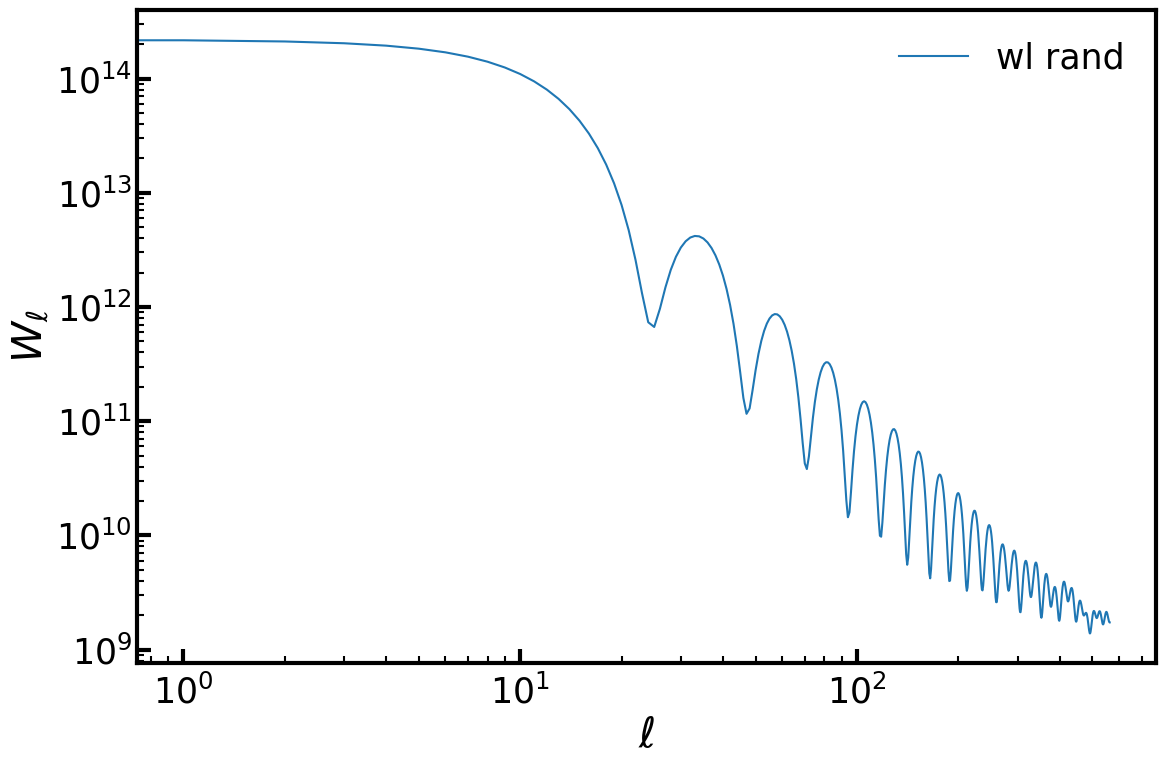

In [33]:
plt.loglog(wl   ,label='wl rand')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()
plt.tight_layout()
plt.savefig('harmonic_window.pdf')

## compute Wigner3j

In [34]:
import sys
import math
import numpy as np 
import healpy as hp
from numba import jit, njit, prange
from timeit import default_timer as timer

_fastmath = False
_parallel = True
_nopython = False

print('_fastmath {}'.format(_fastmath))
print('_parallel {}'.format(_parallel))
print('_nopython {}'.format(_nopython))

@jit(nopython=_nopython, parallel=_parallel, fastmath=_fastmath)
def _compute_matrix(lmax, lnjp1, one_jp1, lng, g, one_g, wl, m):
    # Precompute logarithmic values
    for i in range(4 * lmax + 1):
        lnjp1[i] = np.log(i + 1)
        one_jp1[i] = 1.0 / (i + 1)

    # Compute logarithmic values
    lng[0] = 0.0
    for i in range(1, 2 * lmax + 1):
        lng[i] = lng[i - 1] + np.log((i - 0.5) / i)

    # Compute exponential values
    for i in range(2 * lmax + 1):
        g[i] = np.exp(lng[i])
        one_g[i] = np.exp(-lng[i])

    # Compute the matrix elements
    for i in prange(lmax + 1):
        for j in range(i, lmax + 1):
            tmp = 0.0
            for l in range(j - i, i + j + 1, 2):
                j_sum = i + j + l
                j_2 = j_sum // 2
                tmp += (2.0 * l + 1.0) * wl[l] * g[j_2 - i] * g[j_2 - j] * g[j_2 - l] * one_g[j_2] * one_jp1[j_sum]
            m[i * (lmax + 1) + j] = tmp * 0.25 / math.pi

    # Symmetrize the matrix
    for i in range(lmax + 1):
        for j in range(i, lmax + 1):
            m[j * (lmax + 1) + i] = m[i * (lmax + 1) + j]

    # Scale the matrix elements
    for i in range(lmax + 1):
        for j in range(lmax + 1):
            m[i * (lmax + 1) + j] *= (2.0 * j + 1.0)

    return m.reshape((lmax+1, lmax+1))

class CoupleMat:
    def __init__(self, 
                 Nl, 
                 wl,
                 verbose=True):
        
        self.Nl   = Nl
        self.lmax = Nl-1
        pad       = max(0,2*Nl-1-wl.size)
        self.wl  = np.pad(wl,(0,pad),'constant',constant_values=0)
        self.verbose = verbose
        
        if self.verbose: print('start computation Wigner 3j symbols')

        # Initialize arrays
        self.lnjp1 = np.zeros(4 * self.lmax + 1)
        self.lng = np.zeros(2 * self.lmax + 1)
        self.g = np.zeros(2 * self.lmax + 1)
        self.one_g = np.zeros(2 * self.lmax + 1)
        self.one_jp1 = np.zeros(4 * self.lmax + 1)
        self.m = np.zeros((self.lmax + 1) * (self.lmax + 1))

    def compute_matrix(self):
        return _compute_matrix(self.lmax, self.lnjp1, self.one_jp1, self.lng, self.g, self.one_g, self.wl, self.m)
    

_fastmath False
_parallel True
_nopython False


In [35]:
#iitialize class
couple_mat = CoupleMat(Nl+buffer_ells, wl)
# time execution code
start = timer()
coupling_matrix = couple_mat.compute_matrix()
end = timer()

# print elapsed time
print('elapsed time {:1.5f}s'.format(end - start), flush=True)


start computation Wigner 3j symbols
elapsed time 1.21383s


In [36]:
# if I want to use SHT for the Wigner3j computation
try:
    %time MD = MaskDeconvolution(Nl+buffer_ells,wl,precomputed_Wigner=coupling_matrix)
except:
    %time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))

Precomputing Wigner 3j symbols...
read in Wigner 3j matrix
CPU times: user 118 µs, sys: 22 µs, total: 140 µs
Wall time: 129 µs

Row sums of Mbl:
[1.0006288  1.00038333 1.00038149 1.00040437 1.0004925  1.00047039
 1.00051257 1.00055444 1.00060512 1.000651   1.00077623 1.00097036
 1.00129562 1.00143222 1.00555634 0.98570271 1.16283557]


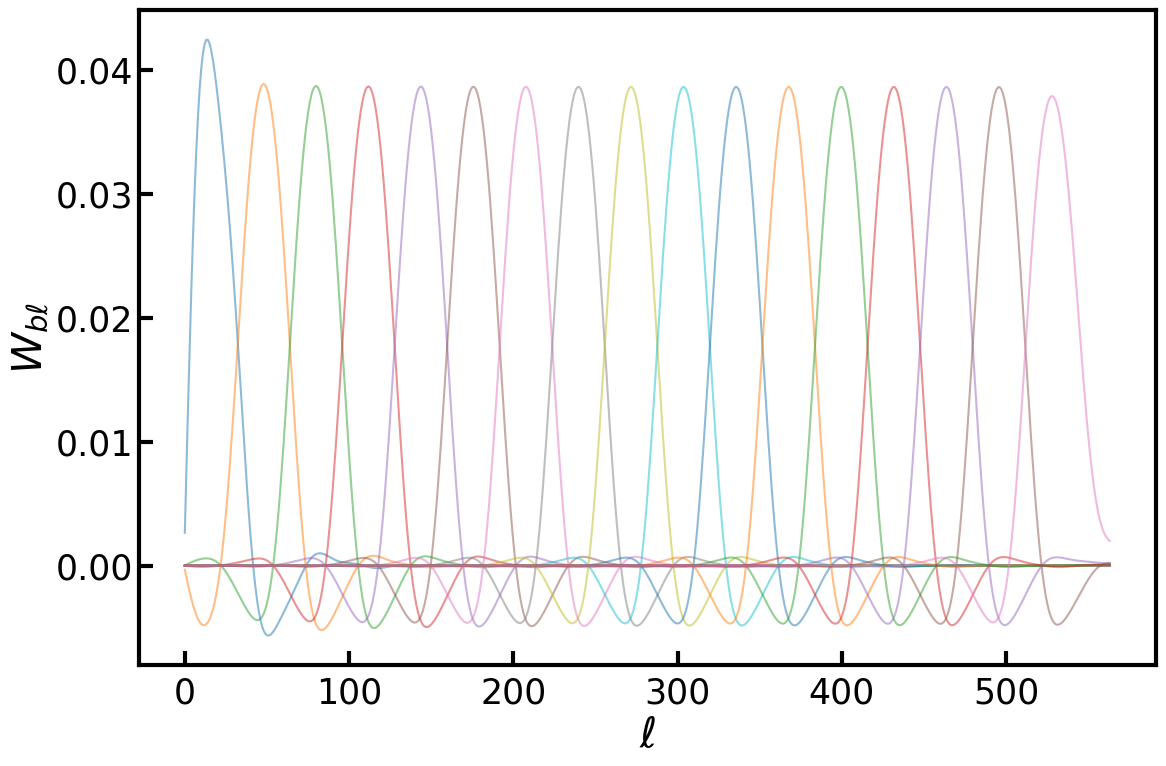

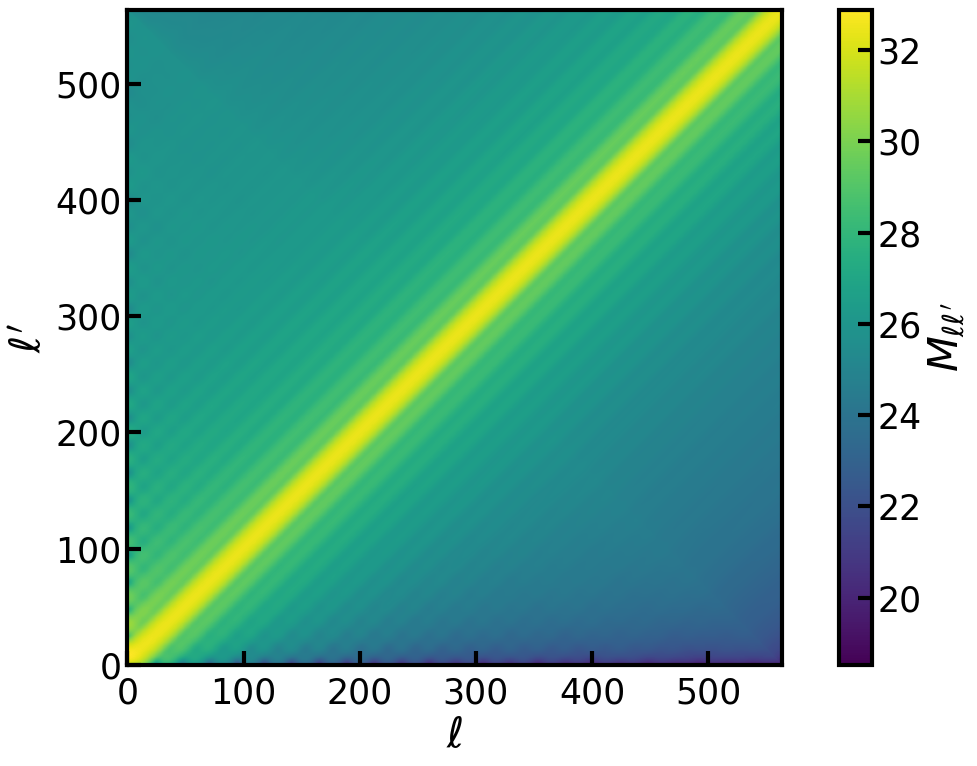

In [37]:
# Plot the matrix:
fig,ax = plt.subplots(1,1)
for i in range(Mbl.shape[0]):
    ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
#ax.legend(bbox_to_anchor=(1.1,1.0))
#ax.set_ylim(-0.07, 0.07)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_{b\ell}$')
plt.tight_layout()
plt.savefig('harmonic_wbl.pdf')
#
# and plot the mode-coupling matrix itself.
fig,ax = plt.subplots(1,1)
mode_coupling = np.log( 1+MD.Mll.clip(0,1e30) )
im = ax.imshow(mode_coupling.T,origin='lower')
ax.set_xlabel(r'$\ell$')
fig.colorbar(im, label=r'$M_{\ell \ell^\prime}$')
ax.set_ylabel(r'$\ell^\prime$')
plt.tight_layout()
plt.savefig('harmonic_mll.pdf')

In [38]:
cl_k = []
for k_idx in np.arange(0, 512, 50):
    hdat = sht(tdata,pdata,wdata[:,k_idx])
    # Do the same for the randoms.
    hran = sht(trand,prand,wrand[:,k_idx])
    # and for the difference of data and randoms:
    hdif = hp.alm2cl(hdat-hran)
    cl_k.append(hdif)
cl_k = np.stack(cl_k)

Sorting & digitizing took  0.007790803909301758  seconds.
Reshaping took  0.03188157081604004  seconds.
Precomputing vs took  0.30602121353149414  seconds.
Computing alm's took  0.6527290344238281  seconds.
Sorting & digitizing took  0.00699925422668457  seconds.
Reshaping took  0.027478694915771484  seconds.
Precomputing vs took  0.029604196548461914  seconds.
Computing alm's took  0.3918273448944092  seconds.
Sorting & digitizing took  0.007199525833129883  seconds.
Reshaping took  0.025967121124267578  seconds.
Precomputing vs took  0.027971267700195312  seconds.
Computing alm's took  0.38202857971191406  seconds.
Sorting & digitizing took  0.007260560989379883  seconds.
Reshaping took  0.02681112289428711  seconds.
Precomputing vs took  0.028939247131347656  seconds.
Computing alm's took  0.3762025833129883  seconds.
Sorting & digitizing took  0.007466793060302734  seconds.
Reshaping took  0.0259552001953125  seconds.
Precomputing vs took  0.028022289276123047  seconds.
Computing a

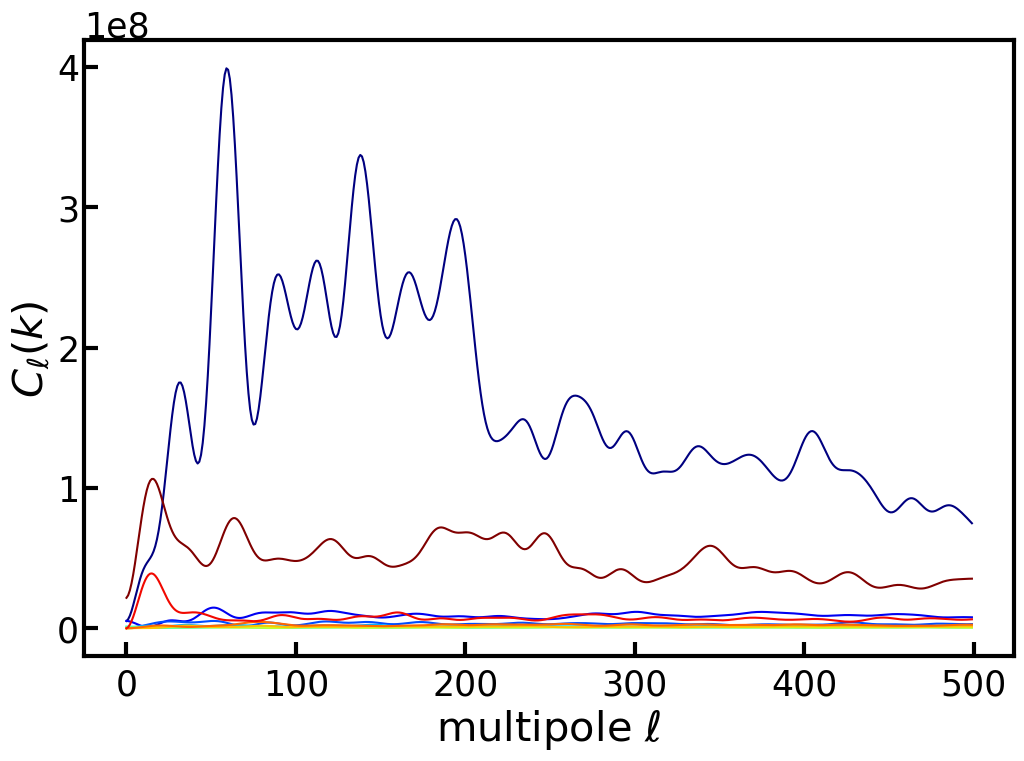

In [39]:
n = len(cl_k)
colors = plt.cm.jet(np.linspace(0,1,n))

for k_idx in range(len(cl_k)):
    plt.plot(np.arange(sht.Nell), cl_k[k_idx],color=colors[k_idx])

plt.xlabel(r'multipole $\ell$')
plt.ylabel(r'$C_{\ell}(k)$')
plt.show()

In [130]:
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata[:,k_idx])
# Do the same for the randoms.
hran = sht(trand,prand,wrand[:,k_idx])
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
#print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))

Sorting & digitizing took  0.009679079055786133  seconds.
Reshaping took  0.03369641304016113  seconds.
Precomputing vs took  0.035802364349365234  seconds.
Computing alm's took  0.3699164390563965  seconds.
Sorting & digitizing took  0.0068280696868896484  seconds.
Reshaping took  0.025030136108398438  seconds.
Precomputing vs took  0.02696990966796875  seconds.
Computing alm's took  0.37192368507385254  seconds.


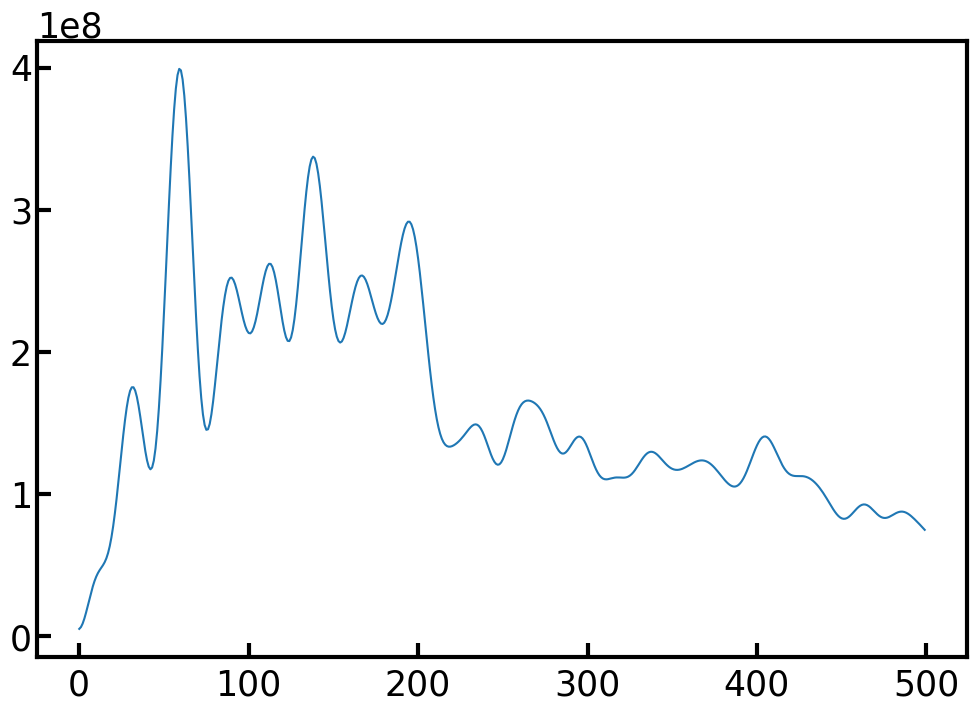

In [131]:
plt.plot(hdif,label='hdif')

In [132]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

In [133]:
print(binned_ells)
print(hdif_decoupled)

[ 79.5 111.5 143.5 175.5 207.5 239.5 271.5 303.5 335.5 367.5 399.5 431.5
 463.5]
[6.86827251e-08 7.36633867e-08 9.31164579e-08 8.08634261e-08
 6.81217681e-08 3.80877706e-08 5.31560640e-08 3.78473086e-08
 3.96737683e-08 3.79893518e-08 4.25148696e-08 3.50604441e-08
 2.95705802e-08]


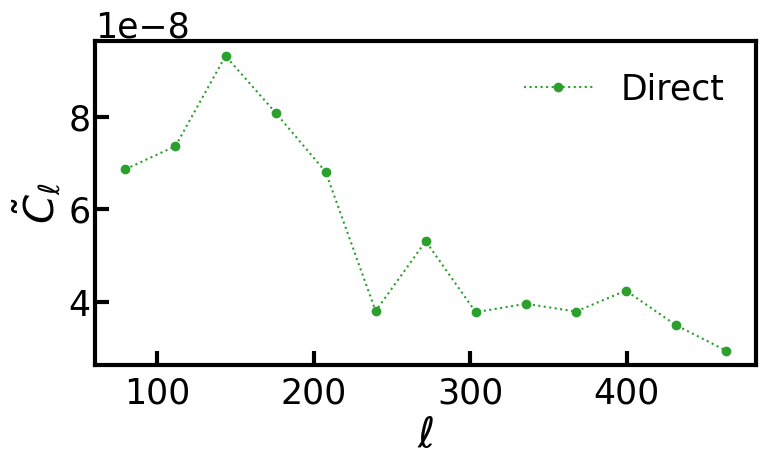

In [134]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function -- we
# expect some differences due to sample variance, but they shouldn't be huge.
# clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
# ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()
plt.tight_layout()
#plt.savefig('harmonic_tildeC.pdf')

## compute theory power spectrum 
$$C_\ell(k)  = \sum_{L \lambda}  F_{\ell L \lambda} \int\frac{dk'}{2\pi\,\bar{\chi}^2}\ P(L/\bar{\chi},k') \sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k-k')\widetilde{K}_k(k-k') $$

In [135]:
from scipy.special import eval_legendre
from scipy.integrate import quad

In [136]:
# Eq. 2.13 in draft 

In [137]:
# the r_ij is cancelling from the cos(theta)
# \hat{n}_j*\hat{n}_k:
qso_vec = np.column_stack([np.sin(tdata)*np.cos(pdata), np.sin(tdata)*np.sin(pdata), np.cos(tdata)])

In [138]:
def norm(ell):
    return (2.*ell+1.)/4./np.pi

In [ ]:
qso_j = 10
#qso_k = 10
#for qso_i in range(Nskew):
# compute K_j * K_k vector for one qso_idx and *all* qso_k
kjkk = FT_mask[qso_j,:]*FT_mask
# computation of cos_theta for qso_i and *all* qso_j
cos_theta_njnk = np.dot(qso_vec[qso_j],qso_vec.T)
# sum over all legendre polynomial up to degree 
lambda_max = 3
tmp = 0.
for lambda_idx in range(lambda_max):
    tmp += np.sum(eval_legendre(lambda_idx, cos_theta_njnk)[:, None] * kjkk[:,k_idx])

In [125]:
def Power_spectrum(kh_par, ell, chi):
    kh = np.sqrt(kh_par**2 + (ell/(chi))**2)
    return plin(kh)

def Cell(l, chi_min, chi_max):
    def integrand(chi):
        pk_chi2 = Power_spectrum(kh_par=0, ell=l, chi=chi)/(chi**2)
        return pk_chi2/(2.*np.pi)
    return quad(integrand, chi_min, chi_max)[0]

#Limber's approximation
kh = np.linspace(1e-4, 10, 10000)
# 2-500 in bins of 10 after 100 
ell_range = np.concatenate([np.arange(2, 100), np.arange(100, 510, 10)])

In [126]:
Cell = np.array([Cell(li, 0.1, 1000) for li in ell_range])

/tmp/ipykernel_711737/3681392338.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand, chi_min, chi_max)[0]


Text(0, 0.5, '$C_{\\ell}$')

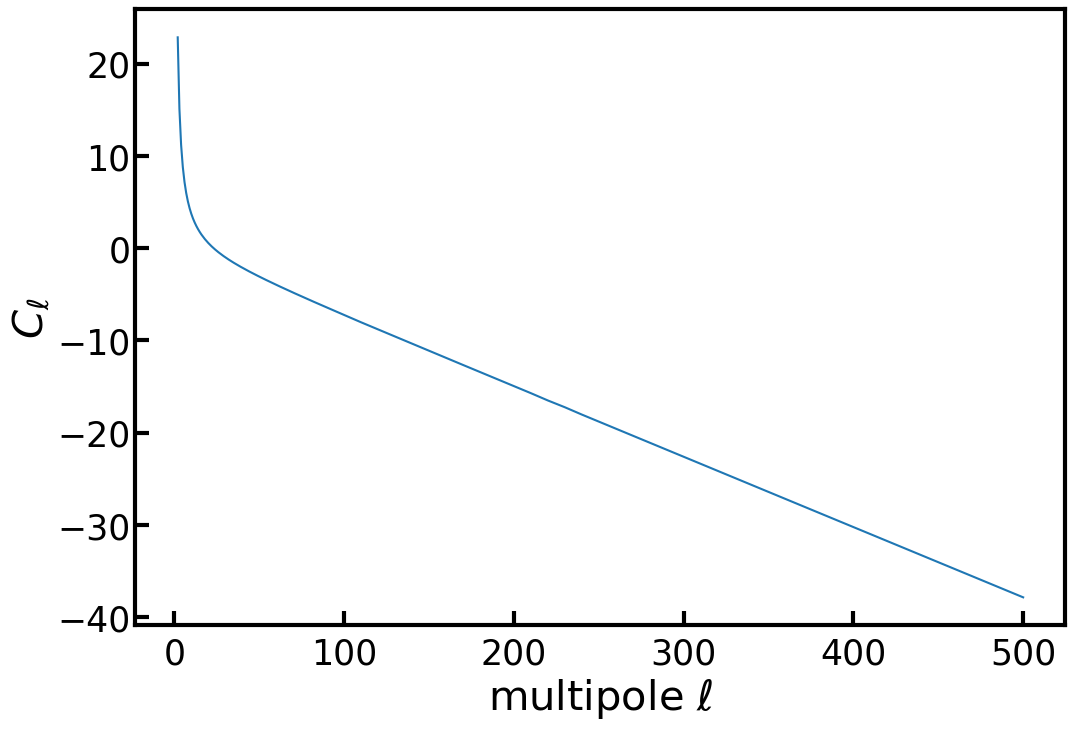

In [127]:
plt.plot(ell_range, Cell)
plt.xlabel(r'multipole $\ell$')
plt.ylabel(r'$C_{\ell}$')